# NN Classification with Pytorch


## Make Classification Data and get it ready

In [2]:
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

In [3]:
n_samples = 1000

# Creating Circles
X,Y = make_circles(n_samples,
                   noise = 0.03,
                   random_state = 42)

In [4]:
X.shape, Y.shape

((1000, 2), (1000,))

In [5]:
print(X[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [6]:
print(Y[:5])

[1 1 1 1 0]


In [7]:
# Make DataFrame of Circle Data

In [8]:
import pandas as pd
# Dictonary
circles = pd.DataFrame(
    {
        'X1': X[:, 0],
        'X2': X[:,1],
        'Lable' : Y
    }
)

circles.head(10)

,X1,X2,Lable
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


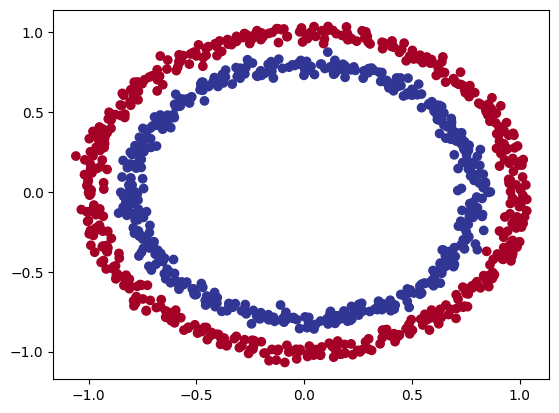

In [9]:
# Visualize , Visualize

plt.scatter(x = X[:, 0],
            y = X[:,1],
            c = Y,
            cmap = plt.cm.RdYlBu)

In [10]:
X.shape, Y.shape

((1000, 2), (1000,))

## Get Ready for Tensors

In [11]:
# Turn dtaa into tensor
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [12]:
X.dtype, Y.dtype

(dtype('float64'), dtype('int64'))

In [13]:
type(X), type(Y)

(numpy.ndarray, numpy.ndarray)

In [14]:
X = torch.from_numpy(X).type(torch.float32)
Y = torch.from_numpy(Y).type(torch.float32)
X.dtype, Y.dtype

(torch.float32, torch.float32)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state= 42)

## Building Model
1. Setup Device Agnosyic code
2. constructr a model
3. DefineLOss function and Optimizer
4. Create a Traning Test Loop


In [16]:
import torch
from torch import nn


# make Device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Our Model
1. Subclass `nn.Module`
2. Create 2 `nn.Linear()` Layers that are capable of handling tha shapes of our data
3. Define a `Forward ` Method : Forward Pass
4. Instantiate an instance of our model calass and send it to the target

In [17]:
X_train.shape

torch.Size([800, 2])

In [18]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 nn.Linear Layers capable of handing the shape of our data
    self.Layer_1 = nn.Linear(in_features = 2, out_features= 5)
    self.Layer_2 = nn.Linear(in_features = 5, out_features =1)

  def forward(self, x):
    return self.Layer_2(self.Layer_1(x)) # X -> Layer_1 -> Layer_2-> Output


model = CircleModel().to(device)
model


CircleModel(
  (Layer_1): Linear(in_features=2, out_features=5, bias=True)
  (Layer_2): Linear(in_features=5, out_features=1, bias=True)
)

### Replicating model using `nn.Sequential`

In [19]:
model_1 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:

model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4722, -0.5572],
                      [ 0.0730,  0.5385],
                      [-0.5928,  0.4804],
                      [ 0.2638,  0.5702],
                      [-0.6295, -0.5390]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2801, -0.7004,  0.0023,  0.6046, -0.0449], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.2041, -0.2814,  0.4339,  0.0020,  0.3614]], device='cuda:0')),
             ('1.bias', tensor([-0.1905], device='cuda:0'))])

In [21]:
# Untrained Predictions
untrained_preds = model_1(X_test.to(device))
print(len(untrained_preds))
print(untrained_preds.shape)
print(len(X_test))
print(X_test.shape)
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{Y_test[:10]}")

200
torch.Size([200, 1])
200
torch.Size([200, 2])

First 10 predictions:
tensor([[-0.0100],
        [-0.3143],
        [ 0.4368],
        [-0.1351],
        [-0.1202],
        [-0.3016],
        [-0.7169],
        [-0.7154],
        [ 0.4596],
        [-0.3408]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Setup Loss Function and Optimizer

1.  For Regression we have MSE, MAE
2. For Classification we have Binary Cross Entropy or Categorical Cross Entropy (Cross Entropy).

Optimizer:
1. SGD
2. AdAm

* For Loss we will use `nn.BCELossWithLogits`

`nn.BCELoss` + `torch.sigmoid` = `nn.BCEWithLogitLoss`

In [22]:
Loss = nn.BCEWithLogitsLoss() # Sigmoid activation is built in
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.01)

### Calculating Accuracy

In [23]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [24]:
from sklearn.metrics import accuracy_score

### Training a Model
1. for loop Epochs
2. Model.train()
3. y_preds = model(X_train)
4. loss = Loss(y_preds, y_train)
5. optimizer.zero_grad()
6. loss.backward()
7. optimizer.step()
8. Model.eval()
9. y_test_preds = Model(X_test)
10. loss_test = Loss(y_test_preds, y_test)
11. if epoch % 10 == 0:

     with torch.inference_mode()
     
     print(f'Epoch: {epoch} | Loss: {loss}| Test_Loss: {loss_test}')
     


#### Going from raw logits-> Prediction Probabilities -> Predictiooon Labels
* Our Model output are going to be raw **Logits**
* We can convert these **Logits** into **Prediction Probabilities** by pasing them in to some kind of activation functin(e.g. `Sigmoid` for Binary Classification and `Softmax` for Multiclass Classification)
* Then we convert the model's predictions by either rounding them or taking the`argmax()`

In [25]:
# Checking the first 5 outputs of the forward pass on the test data
model.eval()
with torch.inference_mode():
  y_logits = model(X_test.to(device))
print(y_logits[:5])

tensor([[-0.0874],
        [-0.1985],
        [-0.0158],
        [-0.1067],
        [-0.3644]], device='cuda:0')


In [26]:
# use the sigmoid activation funcytion on our logits

y_pred_prob = torch.sigmoid(y_logits).squeeze()
print(y_pred_prob[:5])

tensor([0.4782, 0.4505, 0.4961, 0.4733, 0.4099], device='cuda:0')


For our prediction values, we need to perform a range -style rounding on them:

`y_pred_prob` >= 0.5   `y=1`(Class = 1)

`y_pred_prob` < 0.5   `y=0`(Class = 0)

In [27]:
y_pred_labels =torch.round(y_pred_prob[:5])

#### Training Loop

In [35]:
import numpy as np
torch.cuda.manual_seed(42)

epochs = 100
 # put data to target device
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)



for epoch in range(epochs):

  ## Trianing
  model.train()
  # 1. Forward Pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  # 2. Loss/ Accuracy
      ## BCEWithLogitsLoss : Expect logits as input
  loss = Loss(y_logits,
              Y_train)
        ## BCELoss: Expects Prediction probabilities as input
  #loss = Loss(torch.sigmoid(y_logits),
  #          Y_train)

  acc = accuracy_score(y_true = Y_train.detach().cpu().numpy(),
                    y_pred = y_pred.detach().cpu().numpy())
  # 3 Optimizer.zero_grad
  optimizer.zero_grad()

  # 4. Loss Backward

  loss.backward()

  # 5. Optimizer step
  optimizer.step()


#### Testing

  model.eval()
  with torch.inference_mode():
    # 1. Forward Pass
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate test Loss/accuracy
    test_loss = Loss(test_logits,
                     Y_test)

    test_accuracy = accuracy_score(y_true = Y_test.detach().cpu().numpy(),
                                y_pred = test_pred.detach().cpu().numpy())

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test_Loss: {test_loss:.5f} | Test_Accuracy: {test_accuracy}")





Epoch: 0 | Loss: 0.70409 | Accuracy: 0.45% | Test_Loss: 0.70070 | Test_Accuracy: 0.47
Epoch: 10 | Loss: 0.70326 | Accuracy: 0.46% | Test_Loss: 0.70000 | Test_Accuracy: 0.465
Epoch: 20 | Loss: 0.70251 | Accuracy: 0.46% | Test_Loss: 0.69937 | Test_Accuracy: 0.46
Epoch: 30 | Loss: 0.70184 | Accuracy: 0.47% | Test_Loss: 0.69881 | Test_Accuracy: 0.47
Epoch: 40 | Loss: 0.70123 | Accuracy: 0.47% | Test_Loss: 0.69831 | Test_Accuracy: 0.48
Epoch: 50 | Loss: 0.70067 | Accuracy: 0.47% | Test_Loss: 0.69787 | Test_Accuracy: 0.475
Epoch: 60 | Loss: 0.70017 | Accuracy: 0.47% | Test_Loss: 0.69747 | Test_Accuracy: 0.48
Epoch: 70 | Loss: 0.69971 | Accuracy: 0.48% | Test_Loss: 0.69712 | Test_Accuracy: 0.47
Epoch: 80 | Loss: 0.69929 | Accuracy: 0.48% | Test_Loss: 0.69681 | Test_Accuracy: 0.47
Epoch: 90 | Loss: 0.69891 | Accuracy: 0.48% | Test_Loss: 0.69653 | Test_Accuracy: 0.475


In [38]:
## 4. Make Predictions and evaluate the model


# we are importing a function 'plot decission boundary'

import requests
from pathlib import Path

## Download helper function from learn pytorch repo (if it`s already downloadwded)

if Path('helper_function.py').is_file():
  print('File already exists')
else:
  print('Downloading file')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  with open('helper_function.py', 'wb') as f:
    f.write(request.content)

from helper_function import plot_decision_boundary, plot_predictions

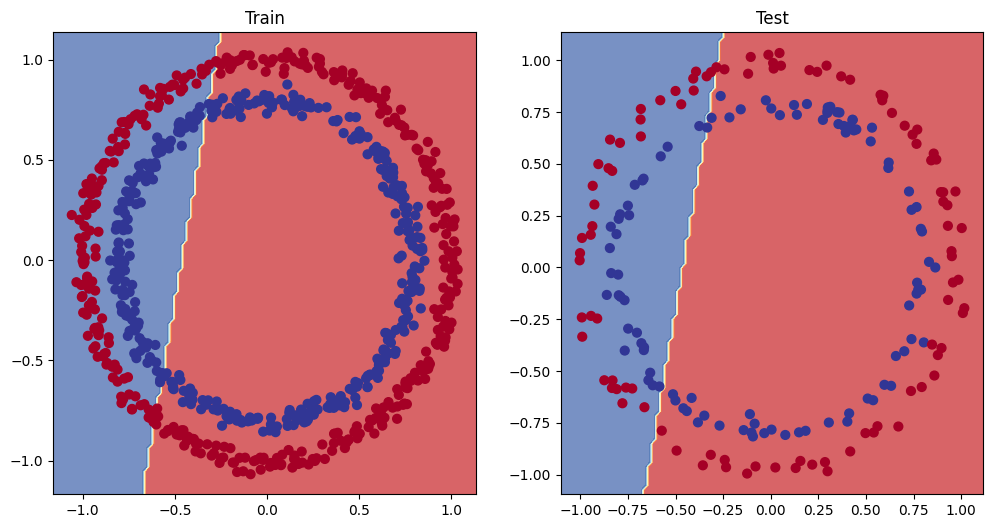

In [40]:
# Plot Deciion boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model = model,
                        X = X_train,
                        y = Y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model = model,
                        X = X_test,
                        y= Y_test)